<a href="https://colab.research.google.com/github/AntoninaRemizova/ML/blob/main/ML_class_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q https://github.com/AntoninaRemizova/ML/archive/refs/heads/main.zip

In [2]:
!nvidia-smi

Mon Dec 15 22:15:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install tensorflow

# импорт

In [29]:
import pandas as pd
import seaborn as sns
import os
import shutil
import random
from glob import glob
import zipfile
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


np.random.seed(42)

In [6]:
os.makedirs('/content/data/tiger', exist_ok=True)
os.makedirs('/content/data/zebra', exist_ok=True)

In [7]:
with zipfile.ZipFile('main.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ml_data')
import shutil

tiger_files = glob('/content/ml_data/ML-main/tiger/*.jpg') + glob('/content/ml_data/ML-main/tiger/*.jpeg') + glob('/content/ml_data/ML-main/tiger/*.png')
for i, file_path in enumerate(tiger_files[:100]):
    shutil.copy(file_path, f'/content/data/tiger/tiger_{i:03d}.jpg')

zebra_files = glob('/content/ml_data/ML-main/zebra/*.jpg') + glob('/content/ml_data/ML-main/zebra/*.jpeg') + glob('/content/ml_data/ML-main/zebra/*.png')
for i, file_path in enumerate(zebra_files[:100]):
    shutil.copy(file_path, f'/content/data/zebra/zebra_{i:03d}.jpg')

tiger_files = glob('/content/data/tiger/*.jpg') + glob('/content/data/tiger/*.jpeg') + glob('/content/data/tiger/*.png')
zebra_files = glob('/content/data/zebra/*.jpg') + glob('/content/data/zebra/*.jpeg') + glob('/content/data/zebra/*.png')

print(f"  Тигры: {len(tiger_files)}")
print(f"  Зебры: {len(zebra_files)}")

  Тигры: 60
  Зебры: 60


In [8]:
def create_directory_structure(base_path='/content/data'):
    directories = [
        'train/tiger',
        'train/zebra',
        'validation/tiger',
        'validation/zebra',
        'test/tiger',
        'test/zebra'
    ]

    for directory in directories:
        os.makedirs(os.path.join(base_path, directory), exist_ok=True)

    return base_path

In [9]:
def split_files(files, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    random.shuffle(files)

    total_files = len(files)
    train_end = int(total_files * train_ratio)
    val_end = train_end + int(total_files * val_ratio)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    return train_files, val_files, test_files

In [10]:
def process_dataset():
    base_path = create_directory_structure()

    tiger_files = glob('/content/ml_data/ML-main/tiger/*.jpg') + \
                  glob('/content/ml_data/ML-main/tiger/*.jpeg') + \
                  glob('/content/ml_data/ML-main/tiger/*.png')

    zebra_files = glob('/content/ml_data/ML-main/zebra/*.jpg') + \
                  glob('/content/ml_data/ML-main/zebra/*.jpeg') + \
                  glob('/content/ml_data/ML-main/zebra/*.png')

    print(f"Найдено файлов:")
    print(f"  Тигры: {len(tiger_files)}")
    print(f"  Зебры: {len(zebra_files)}")

    tiger_train, tiger_val, tiger_test = split_files(tiger_files)
    zebra_train, zebra_val, zebra_test = split_files(zebra_files)

    print(f"\nРаспределение файлов тигров:")
    print(f"  Train: {len(tiger_train)}")
    print(f"  Validation: {len(tiger_val)}")
    print(f"  Test: {len(tiger_test)}")

    print(f"\nРаспределение файлов зебр:")
    print(f"  Train: {len(zebra_train)}")
    print(f"  Validation: {len(zebra_val)}")
    print(f"  Test: {len(zebra_test)}")

    def copy_files(file_list, source_dir, target_dir, prefix):
        for i, file_path in enumerate(file_list):
            ext = os.path.splitext(file_path)[1]
            new_filename = f"{prefix}_{i:03d}{ext}"
            shutil.copy(file_path, os.path.join(target_dir, new_filename))

    copy_files(tiger_train, '/content/ml_data/ML-main/tiger',
               '/content/data/train/tiger', 'tiger')
    copy_files(tiger_val, '/content/ml_data/ML-main/tiger',
               '/content/data/validation/tiger', 'tiger')
    copy_files(tiger_test, '/content/ml_data/ML-main/tiger',
               '/content/data/test/tiger', 'tiger')

    copy_files(zebra_train, '/content/ml_data/ML-main/zebra',
               '/content/data/train/zebra', 'zebra')
    copy_files(zebra_val, '/content/ml_data/ML-main/zebra',
               '/content/data/validation/zebra', 'zebra')
    copy_files(zebra_test, '/content/ml_data/ML-main/zebra',
               '/content/data/test/zebra', 'zebra')

    print(f"\nФайлы распределены по папкам:")

    for split in ['train', 'validation', 'test']:
        for animal in ['tiger', 'zebra']:
            path = f'/content/data/{split}/{animal}'
            files_count = len(glob(os.path.join(path, '*')))
            print(f"  {split}/{animal}: {files_count} файлов")

    return base_path

# разделение на train validation test

In [11]:
process_dataset()

Найдено файлов:
  Тигры: 60
  Зебры: 60

Распределение файлов тигров:
  Train: 42
  Validation: 9
  Test: 9

Распределение файлов зебр:
  Train: 42
  Validation: 9
  Test: 9

Файлы распределены по папкам:
  train/tiger: 42 файлов
  train/zebra: 42 файлов
  validation/tiger: 9 файлов
  validation/zebra: 9 файлов
  test/tiger: 9 файлов
  test/zebra: 9 файлов


'/content/data'

# CNN

In [15]:
base_path = '/content/data'

def create_tf_datasets():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/train',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/validation',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/test',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary',
        shuffle=False
    )

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = create_tf_datasets()


class_names = train_ds.class_names
print(f"Классы: {class_names}")
print(f"Размер обучающей выборки: {len(train_ds.file_paths) if hasattr(train_ds, 'file_paths') else 'N/A'}")

Found 84 files belonging to 2 classes.
Found 18 files belonging to 2 classes.
Found 18 files belonging to 2 classes.
Классы: ['tiger', 'zebra']
Размер обучающей выборки: 84


In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [14]:
model = tf.keras.Sequential([
    # Нормализация входных данных: переводим пиксели из диапазона [0, 255] в [0, 1]
    # Это ускоряет обучение и делает градиенты более стабильными
    tf.keras.layers.Rescaling(1./255, input_shape=(*IMG_SIZE, 3)),

    # Первый свёрточный блок:
    # — 32 фильтра размером 3×3, шаг (stride) по умолчанию = 1
    # — ReLU добавляет нелинейность и ускоряет сходимость
    tf.keras.layers.Conv2D(32, 3, activation='relu'),

    # Макс-пулинг 2×2 (по умолчанию) уменьшает пространственное разрешение в 2 раза,
    # сохраняя наиболее значимые признаки и снижая вычислительную нагрузку
    tf.keras.layers.MaxPooling2D(),

    # Второй свёрточный блок: удваиваем число фильтров до 64,
    # чтобы модель могла учить более сложные комбинации признаков
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # Третий свёрточный блок: ещё больше признаков — 128 фильтров
    tf.keras.layers.Conv2D(128, 3, activation='relu'),

    # Глобальное усреднение по пространственным измерениям:
    # каждый канал (128 штук) превращается в одно число — среднее значение по всей карте признаков.
    # Это эффективная альтернатива полносвязным слоям, уменьшает риск переобучения.
    tf.keras.layers.GlobalAveragePooling2D(),

    # Выходной слой для бинарной классификации:
    # один нейрон с сигмоидной активацией выдаёт вероятность принадлежности
    # к положительному классу (например, "кенгуру" вместо "капибары")
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Компилируем модель
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall', F1Score(average='macro')])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4940 - f1_score: 0.6768 - loss: 0.6944 - precision: 0.3892 - recall: 0.4452 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - val_loss: 0.6898 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5039 - f1_score: 0.6701 - loss: 0.6867 - precision: 0.5039 - recall: 1.0000 - val_accuracy: 0.5556 - val_f1_score: 0.6667 - val_loss: 0.6859 - val_precision: 0.5294 - val_recall: 1.0000
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.6828 - f1_score: 0.6897 - loss: 0.6782 - precision: 0.6329 - recall: 0.9329 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - val_loss: 0.6855 - val_precision: 0.5000 - val_recall: 0.4444
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.6339 - f1_score: 0.6868 - loss: 0.6773 - precision: 0.6695 - recall: 0.6008 - val_accuracy: 0.6667 - val_f1_score: 0.6667 - val_loss: 0.6763 - val_precision: 0.6154 - val_recall: 0.8889
Ep

In [17]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_ds, verbose=0)

print("\n--- Тестовые метрики ---")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-score:  {test_f1:.4f}")


--- Тестовые метрики ---
Accuracy:  0.6667
Precision: 0.6667
Recall:    0.6667
F1-score:  0.6667


In [19]:
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.append(labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred.append((preds > 0.5).astype(int).flatten())

# Объединяем все батчи в один массив
y_true = np.concatenate(y_true).flatten()
y_pred = np.concatenate(y_pred).flatten()

print("\n--- Подробный отчёт по классам ---")
class_names = test_ds.class_names
print(classification_report(y_true, y_pred, target_names=class_names));


--- Подробный отчёт по классам ---
              precision    recall  f1-score   support

       tiger       0.67      0.67      0.67         9
       zebra       0.67      0.67      0.67         9

    accuracy                           0.67        18
   macro avg       0.67      0.67      0.67        18
weighted avg       0.67      0.67      0.67        18



## матрица ошибок

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


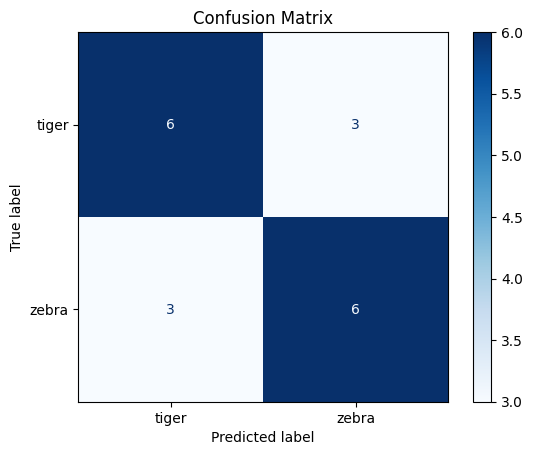

In [28]:
y_true = np.concatenate([y for _, y in test_ds], axis=0).flatten()
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# VGG

In [33]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10

In [31]:
# Загружаем VGG16 без головы
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Замораживаем веса (опционально, особенно на малом датасете)
base_model.trainiable = False

# Строим модель
inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
x = preprocess_input(inputs)  # ← критически важный шаг для VGG!
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Компиляция
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        513 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 14,715,201 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= EPOCHS,
    verbose=1
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 100s 23s/step - accuracy: 0.4016 - loss: 5.8982 - val_accuracy: 0.5556 - val_loss: 0.6879
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 559ms/step - accuracy: 0.5415 - loss: 0.6752 - val_accuracy: 0.6111 - val_loss: 0.6701
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 530ms/step - accuracy: 0.6019 - loss: 0.6367 - val_accuracy: 0.7778 - val_loss: 0.6822
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - accuracy: 0.8110 - loss: 0.5652 - val_accuracy: 0.6667 - val_loss: 0.8064
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.7401 - loss: 0.5198 - val_accuracy: 0.5556 - val_loss: 1.0756
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - accuracy: 0.6990 - loss: 0.5588 - val_accuracy: 0.7222 - val_loss: 0.7795
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 566ms/step - accuracy: 0.8523 - loss: 0.4369 - val_accuracy: 0.7778 - val_loss: 0.9934
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 583ms/step - accuracy: 0.8620 - loss: 0.3487 - val_accuracy: 0.7778 - val_loss

In [35]:
y_true = []
y_pred_proba = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0).flatten()
    y_pred_proba.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = (np.array(y_pred_proba) > 0.5).astype(int)

## матрица ошибок

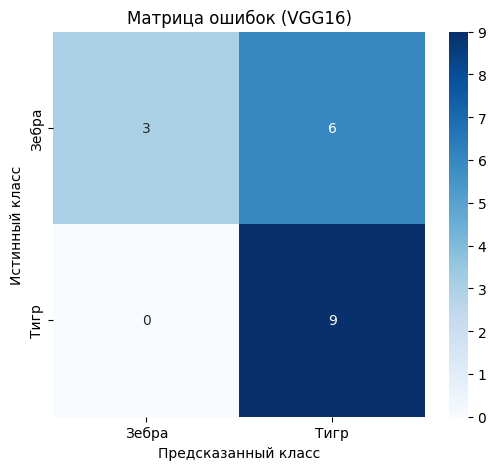

In [36]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Зебра', 'Тигр'],
            yticklabels=['Зебра', 'Тигр'])
plt.title("Матрица ошибок (VGG16)")
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.show()


In [37]:
print(classification_report(y_true, y_pred, target_names=['zebra', 'tiger']))

              precision    recall  f1-score   support

       zebra       1.00      0.33      0.50         9
       tiger       0.60      1.00      0.75         9

    accuracy                           0.67        18
   macro avg       0.80      0.67      0.62        18
weighted avg       0.80      0.67      0.62        18

